In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from statsmodels.graphics.regressionplots import plot_fit
import statsmodels.api as sm

# Load the dataset
data = pd.read_csv('dataset.csv')

data.head(5)

,tanggal,Luas Panen Padi,GKPTP,GKPTPG,GKGTP,Beras
0,1/6/2022,10,4140,4410,5230,9970
1,2/6/2022,10,4160,4420,5250,9970
2,3/6/2022,10,4180,4410,5230,9890
3,4/6/2022,10,4160,4410,5230,9760
4,5/6/2022,10,4180,4420,5230,9840


In [44]:
data.shape
data.describe()

,GKPTP,GKPTPG,GKGTP,Beras
count,1016.000000,1016.000000,1016.000000,1016.000000
mean,5131.879921,5435.797244,6324.143701,11550.364173
std,906.149059,923.300545,1036.229265,1717.079536
min,4060.000000,4320.000000,5080.000000,8860.000000
25%,4410.000000,4690.000000,5580.000000,10157.500000
50%,4850.000000,5165.000000,6035.000000,11030.000000
75%,5502.500000,5855.000000,6730.000000,12935.000000
max,7390.000000,7860.000000,9300.000000,16100.000000


<AxesSubplot:xlabel='Beras', ylabel='Count'>

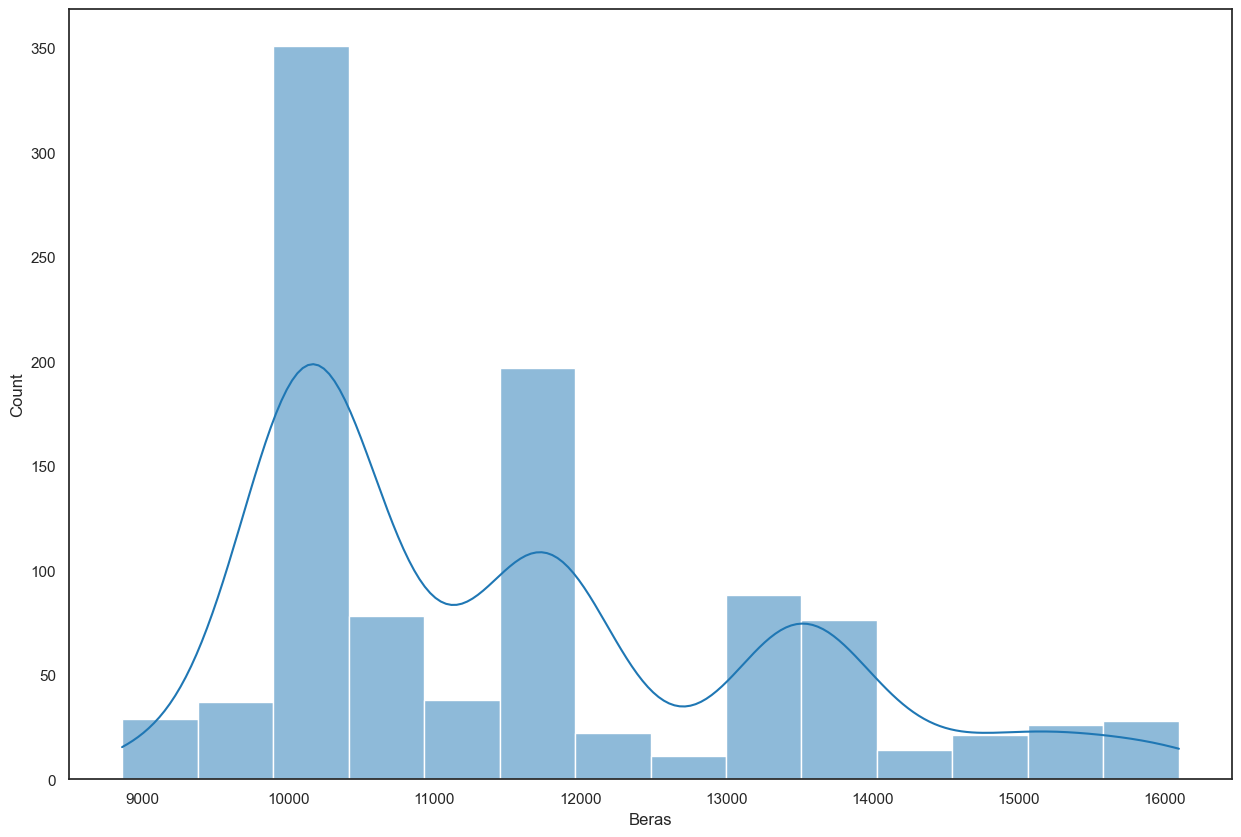

In [45]:
plt.figure(figsize=(15,10))
plt.tight_layout()
sns.histplot(data['Beras'], kde=True)

In [46]:
# Convert 'tanggal' to datetime
data['tanggal'] = pd.to_datetime(data['tanggal'], format='%d/%m/%Y', errors='coerce')

data.head(10)

,tanggal,Luas Panen Padi,GKPTP,GKPTPG,GKGTP,Beras
0,2022-06-01,10,4140,4410,5230,9970
1,2022-06-02,10,4160,4420,5250,9970
2,2022-06-03,10,4180,4410,5230,9890
3,2022-06-04,10,4160,4410,5230,9760
4,2022-06-05,10,4180,4420,5230,9840
5,2022-06-06,10,4180,4420,5280,9910
6,2022-06-07,10,4200,4430,5280,9910
7,2022-06-08,10,4200,4630,5280,9910
8,2022-06-09,30,4250,4520,5240,9800
9,2022-07-14,10,4260,4500,5190,9900


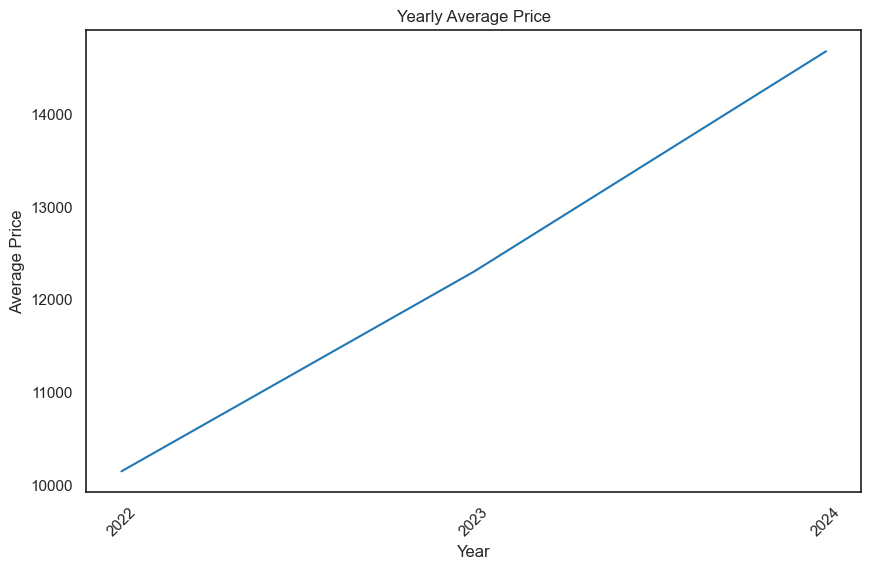

In [47]:
# Visualize data per year before processing
data['year'] = data['tanggal'].apply(lambda x: pd.Timestamp(x).year)
yearly_data = data.groupby('year')['Beras'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(yearly_data['year'], yearly_data['Beras'])
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.title('Yearly Average Price')
plt.xticks(yearly_data['year'], rotation=45)
plt.show()

In [48]:
# Convert datetime to ordinal
data['tanggal'] = data['tanggal'].apply(lambda x: x.toordinal() if pd.notnull(x) else np.nan)

# Handle missing values
data = data.dropna()

# Replace non-numeric values with NaN
data = data.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the mean of the column
data = data.fillna(data.mean())

data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tanggal          1016 non-null   int64  
 1   Luas Panen Padi  1016 non-null   float64
 2   GKPTP            1016 non-null   int64  
 3   GKPTPG           1016 non-null   int64  
 4   GKGTP            1016 non-null   int64  
 5   Beras            1016 non-null   int64  
 6   year             1016 non-null   int64  
dtypes: float64(1), int64(6)
memory usage: 55.7 KB


,tanggal,Luas Panen Padi,GKPTP,GKPTPG,GKGTP,Beras,year
0,738307,10.0,4140,4410,5230,9970,2022
1,738308,10.0,4160,4420,5250,9970,2022
2,738309,10.0,4180,4410,5230,9890,2022
3,738310,10.0,4160,4410,5230,9760,2022
4,738311,10.0,4180,4420,5230,9840,2022
5,738312,10.0,4180,4420,5280,9910,2022
6,738313,10.0,4200,4430,5280,9910,2022
7,738314,10.0,4200,4630,5280,9910,2022
8,738315,30.0,4250,4520,5240,9800,2022
9,738350,10.0,4260,4500,5190,9900,2022


In [49]:
# Define the features and the target
X = data[['tanggal', 'GKPTP', 'GKPTPG', 'GKGTP']]
y = data['Beras']

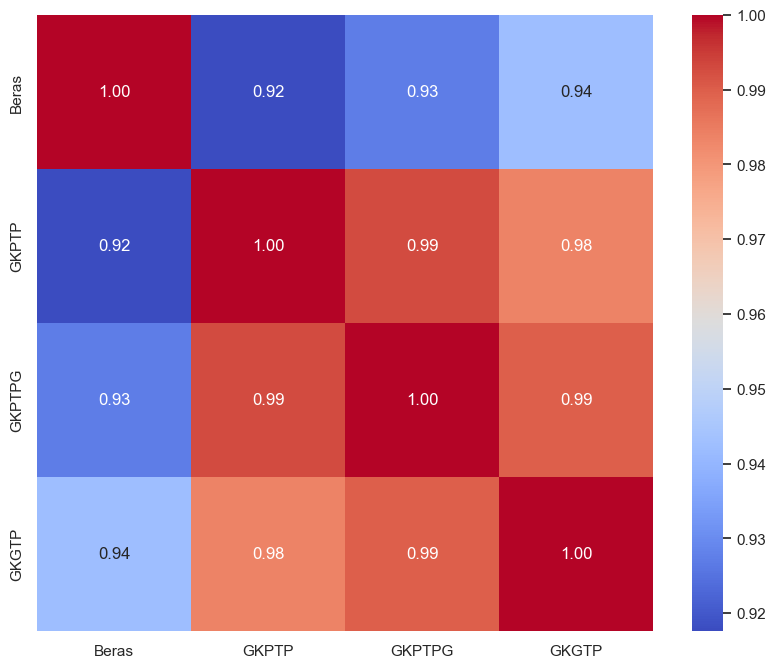

In [50]:
corr = data[['Beras', 'GKPTP', 'GKPTPG', 'GKGTP']].corr()
# Membuat scatter plot matriks
plt.figure(figsize=(10, 8))
sns.set_theme(style="white", palette=None)
# Draw a heatmap with the numeric values in each cell
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)
plt.show()

In [51]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [52]:
X_train.info()
X_train.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 812 entries, 5 to 684
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   tanggal  812 non-null    int64
 1   GKPTP    812 non-null    int64
 2   GKPTPG   812 non-null    int64
 3   GKGTP    812 non-null    int64
dtypes: int64(4)
memory usage: 31.7 KB


,tanggal,GKPTP,GKPTPG,GKGTP
5,738312,4180,4420,5280
351,738361,4240,4480,5290
689,738699,5360,5540,6300
732,738742,5390,5640,6490
648,738658,5100,5310,6080


In [53]:
regressor = RandomForestRegressor()
regressor.fit(X_train,y_train)

RandomForestRegressor()

In [54]:
y_prediction =  regressor.predict(X_test)
y_prediction 

array([10216.6       ,  9864.33166667, 15460.8       , 11705.7       ,
       13789.9       ,  9944.6       , 10068.5       , 11830.4       ,
        9891.6       , 10713.        , 11516.8       , 13556.4       ,
       10026.5       ,  9488.74857143, 16072.7       , 10059.3       ,
       12087.8       , 10293.8       , 10391.7       , 11738.6       ,
       15998.7       , 13347.9       , 13650.1       , 10130.2       ,
       10420.8       , 10314.1       , 11046.7       ,  9738.01      ,
       13528.8       , 13453.8       , 13424.        ,  9872.2       ,
       14357.1       , 10212.8       , 11766.1       , 12336.8       ,
       13371.2       , 11797.3       , 11800.1       , 10199.9       ,
       10069.        , 11796.5       ,  9940.3       ,  9909.        ,
       10475.9       , 10861.2       ,  9738.01      , 14845.2       ,
       10173.        , 10070.93      , 11761.        ,  9970.3       ,
       15990.1       , 11822.6       , 13412.        , 13408.7       ,
      

In [55]:
score = r2_score(y_test,y_prediction)
mean_error = mean_squared_error(y_test,y_prediction)
mae = mean_absolute_error(y_test,y_prediction)
print("R2 SCORE is", score)
print("mean_sqrd_error is ", mean_error)
print("Root mean squared error of is",np.sqrt(mean_error))
print("Mean Absolute error is", mae)

R2 SCORE is 0.9865524117854386
mean_sqrd_error is  40660.994632258175
Root mean squared error of is 201.64571563080176
Mean Absolute error is 79.26428688141928


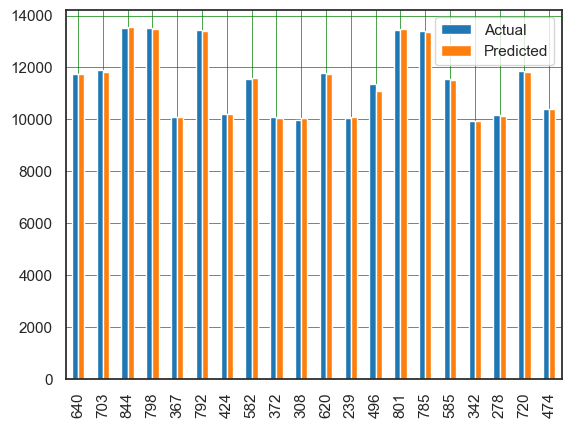

In [56]:
df1 = pd.DataFrame({'Actual': y_test[100:120], 'Predicted': y_prediction[100:120]})
df1.plot(kind='bar')
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [57]:
# Calculate the difference and percentage error
result = pd.DataFrame()
result["ACTUAL PRICE"] = y_test
result["PREDICTED PRICE"] = y_prediction
result["DIFFERENCE"] = result["ACTUAL PRICE"] - result["PREDICTED PRICE"]
result["PERCENTAGE ERROR"] = ( abs(result["ACTUAL PRICE"] - result["PREDICTED PRICE"] ) / result["ACTUAL PRICE"] ) * 100
result.head(15)

,ACTUAL PRICE,PREDICTED PRICE,DIFFERENCE,PERCENTAGE ERROR
251,10240,10216.600000,23.400000,0.228516
75,10280,9864.331667,415.668333,4.043466
941,15840,15460.800000,379.200000,2.393939
658,11660,11705.700000,-45.700000,0.391938
886,13810,13789.900000,20.100000,0.145547
1,9970,9944.600000,25.400000,0.254764
240,10050,10068.500000,-18.500000,0.184080
721,11850,11830.400000,19.600000,0.165401
27,9880,9891.600000,-11.600000,0.117409
489,10720,10713.000000,7.000000,0.065299
